In [1]:
import numpy as np
import pandas as pd
import math

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.max_rows = None  # 모든 row 내용 print
pd.options.display.max_rows = 20

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.

In [3]:
# Provide the names for the columns since the CSV file with the data does not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']

In [4]:
# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                     sep=',', names=feature_names, header=None, encoding='latin-1')

 We'll then randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent.

In [5]:
car_data = car_data.reindex(np.random.permutation(car_data.index))
# or equivalently,
# car_data = car_data.sample(frac=1)

In [6]:
print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


In [7]:
car_data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
85,1,125,mitsubishi,gas,std,four,sedan,fwd,front,96.30,...,122,2bbl,3.35,3.46,8.50,88,5000,25,32,6989
132,3,150,saab,gas,std,two,hatchback,fwd,front,99.10,...,121,mpfi,3.54,3.07,9.31,110,5250,21,28,11850
140,2,83,subaru,gas,std,two,hatchback,4wd,front,93.30,...,108,2bbl,3.62,2.64,8.70,73,4400,26,31,7603
197,-1,74,volvo,gas,std,four,wagon,rwd,front,104.30,...,141,mpfi,3.78,3.15,9.50,114,5400,24,28,16515
107,0,161,peugot,gas,std,four,sedan,rwd,front,107.90,...,120,mpfi,3.46,3.19,8.40,97,5000,19,24,11900


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [8]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
107,0,161,peugot,gas,std,four,sedan,rwd,front,107.90,...,120,mpfi,3.46,3.19,8.40,97,5000,19,24,11900
65,0,118,mazda,gas,std,four,sedan,rwd,front,104.90,...,140,mpfi,3.76,3.16,8.00,120,5000,19,27,18280
123,-1,74,plymouth,gas,std,four,wagon,fwd,front,103.30,...,122,2bbl,3.35,3.46,8.50,88,5000,24,30,8921


In [9]:
car_data.describe()

,symboling,wheel-base,length,width,height,weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,25.22,30.75
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,3.97,6.54,6.89
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,13.00,16.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,19.00,25.00
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,24.00,30.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,30.00,34.00
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,49.00,54.00


In [10]:
LABEL = 'price'

numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

categorical_feature_names

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [11]:
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [12]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
85,1,125,96.30,172.40,65.40,51.60,2365,122,88,5000,25,32,3.35,3.46,8.50
132,3,150,99.10,186.60,66.50,56.10,2658,121,110,5250,21,28,3.54,3.07,9.31
140,2,83,93.30,157.30,63.80,55.70,2240,108,73,4400,26,31,3.62,2.64,8.70
197,-1,74,104.30,188.80,67.20,57.50,3042,141,114,5400,24,28,3.78,3.15,9.50
107,0,161,107.90,186.70,68.40,56.70,3020,120,97,5000,19,24,3.46,3.19,8.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,3,145,95.90,173.20,66.30,50.20,2811,156,145,5000,19,24,3.60,3.90,7.00
3,2,164,99.80,176.60,66.20,54.30,2337,109,102,5500,24,30,3.19,3.40,10.00
176,-1,65,102.40,175.60,66.50,54.90,2414,122,92,4200,27,32,3.31,3.54,8.70
202,-1,95,109.10,188.80,68.90,55.50,3012,173,134,5500,18,23,3.58,2.87,8.80


In [13]:
car_data[numeric_feature_names].describe()

,symboling,wheel-base,length,width,height,weight,engine-size,city-mpg,highway-mpg,compression-ratio
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,25.22,30.75,10.14
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,6.54,6.89,3.97
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,13.00,16.00,7.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,19.00,25.00,8.60
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,24.00,30.00,9.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,30.00,34.00,9.40
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,49.00,54.00,23.00


In [14]:
# Coerce the numeric features to numbers. This is necessary because the model crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
    car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors ='coerce')

"""
errors: error는 총 3개의 옵션이 존재합니다.
- errors = 'ignore' -> 만약 숫자로 변경할 수 없는 데이터라면 숫자로 변경하지 않고 원본 데이터를 그대로 반환합니다.
- errors = 'coerce' -> 만약 숫자로 변경할 수 없는 데이터라면 기존 데이터를 지우고 NaN으로 설정하여 반환합니다.
- errors = 'raise' -> 만약 숫자로 변경할 수 없는 데이터라면 에러를 일으키며 코드를 중단합니다."""
    
# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [15]:
car_data.shape

(205, 26)

In [16]:
X = car_data[numeric_feature_names].copy()
y = car_data['price'].copy()

In [17]:
X.columns

Index(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'bore', 'stroke', 'compression-ratio'],
      dtype='object')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 )

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=3, input_shape=(15,), activation='relu'))
model.add(tf.keras.layers.Dense(units=1))
model.compile(tf.keras.optimizers.Adam(learning_rate=0.01),
             loss='mean_squared_error',
             metrics=[tf.keras.metrics.MeanSquaredError()])

In [20]:
batch_size=16
epochs=1000
model.fit(X_train, y_train, epochs=epochs, batch_size= batch_size)

Epoch 1/1000
11/11 [==============================] - 1s 2ms/step - loss: 248939072.0000 - mean_squared_error: 248939072.0000
Epoch 2/1000
11/11 [==============================] - 0s 3ms/step - loss: 248920192.0000 - mean_squared_error: 248920192.0000
Epoch 3/1000
11/11 [==============================] - 0s 2ms/step - loss: 248911600.0000 - mean_squared_error: 248911600.0000
Epoch 4/1000
11/11 [==============================] - 0s 3ms/step - loss: 248900976.0000 - mean_squared_error: 248900976.0000
Epoch 5/1000
11/11 [==============================] - 0s 3ms/step - loss: 248893696.0000 - mean_squared_error: 248893696.0000
Epoch 6/1000
11/11 [==============================] - 0s 4ms/step - loss: 248887888.0000 - mean_squared_error: 248887888.0000
Epoch 7/1000
11/11 [==============================] - 0s 3ms/step - loss: 248881424.0000 - mean_squared_error: 248881424.0000
Epoch 8/1000
11/11 [==============================] - 0s 3ms/step - loss: 248874288.0000 - mean_squared_error: 2488742

Epoch 65/1000
11/11 [==============================] - 0s 2ms/step - loss: 248700576.0000 - mean_squared_error: 248700576.0000
Epoch 66/1000
11/11 [==============================] - 0s 2ms/step - loss: 248697680.0000 - mean_squared_error: 248697680.0000
Epoch 67/1000
11/11 [==============================] - 0s 2ms/step - loss: 248694912.0000 - mean_squared_error: 248694912.0000
Epoch 68/1000
11/11 [==============================] - 0s 2ms/step - loss: 248691968.0000 - mean_squared_error: 248691968.0000
Epoch 69/1000
11/11 [==============================] - 0s 2ms/step - loss: 248689088.0000 - mean_squared_error: 248689088.0000
Epoch 70/1000
11/11 [==============================] - 0s 2ms/step - loss: 248686224.0000 - mean_squared_error: 248686224.0000
Epoch 71/1000
11/11 [==============================] - 0s 2ms/step - loss: 248683392.0000 - mean_squared_error: 248683392.0000
Epoch 72/1000
11/11 [==============================] - 0s 2ms/step - loss: 248680496.0000 - mean_squared_error:

11/11 [==============================] - 0s 2ms/step - loss: 248514736.0000 - mean_squared_error: 248514736.0000
Epoch 130/1000
11/11 [==============================] - 0s 2ms/step - loss: 248511856.0000 - mean_squared_error: 248511856.0000
Epoch 131/1000
11/11 [==============================] - 0s 2ms/step - loss: 248509008.0000 - mean_squared_error: 248509008.0000
Epoch 132/1000
11/11 [==============================] - 0s 2ms/step - loss: 248506144.0000 - mean_squared_error: 248506144.0000
Epoch 133/1000
11/11 [==============================] - 0s 2ms/step - loss: 248503168.0000 - mean_squared_error: 248503168.0000
Epoch 134/1000
11/11 [==============================] - 0s 2ms/step - loss: 248500272.0000 - mean_squared_error: 248500272.0000
Epoch 135/1000
11/11 [==============================] - 0s 2ms/step - loss: 248497408.0000 - mean_squared_error: 248497408.0000
Epoch 136/1000
11/11 [==============================] - 0s 2ms/step - loss: 248494528.0000 - mean_squared_error: 248494

11/11 [==============================] - 0s 2ms/step - loss: 248329184.0000 - mean_squared_error: 248329184.0000
Epoch 194/1000
11/11 [==============================] - 0s 3ms/step - loss: 248326336.0000 - mean_squared_error: 248326336.0000
Epoch 195/1000
11/11 [==============================] - 0s 3ms/step - loss: 248323440.0000 - mean_squared_error: 248323440.0000
Epoch 196/1000
11/11 [==============================] - 0s 3ms/step - loss: 248320528.0000 - mean_squared_error: 248320528.0000
Epoch 197/1000
11/11 [==============================] - 0s 3ms/step - loss: 248317600.0000 - mean_squared_error: 248317600.0000
Epoch 198/1000
11/11 [==============================] - 0s 3ms/step - loss: 248314752.0000 - mean_squared_error: 248314752.0000
Epoch 199/1000
11/11 [==============================] - 0s 3ms/step - loss: 248311808.0000 - mean_squared_error: 248311808.0000
Epoch 200/1000
11/11 [==============================] - 0s 3ms/step - loss: 248308912.0000 - mean_squared_error: 248308

11/11 [==============================] - 0s 3ms/step - loss: 248143296.0000 - mean_squared_error: 248143296.0000
Epoch 258/1000
11/11 [==============================] - 0s 3ms/step - loss: 248140320.0000 - mean_squared_error: 248140320.0000
Epoch 259/1000
11/11 [==============================] - 0s 3ms/step - loss: 248137376.0000 - mean_squared_error: 248137376.0000
Epoch 260/1000
11/11 [==============================] - 0s 3ms/step - loss: 248134480.0000 - mean_squared_error: 248134480.0000
Epoch 261/1000
11/11 [==============================] - 0s 3ms/step - loss: 248131552.0000 - mean_squared_error: 248131552.0000
Epoch 262/1000
11/11 [==============================] - 0s 2ms/step - loss: 248128640.0000 - mean_squared_error: 248128640.0000
Epoch 263/1000
11/11 [==============================] - 0s 2ms/step - loss: 248125712.0000 - mean_squared_error: 248125712.0000
Epoch 264/1000
11/11 [==============================] - 0s 2ms/step - loss: 248122944.0000 - mean_squared_error: 248122

11/11 [==============================] - 0s 2ms/step - loss: 247960624.0000 - mean_squared_error: 247960624.0000
Epoch 321/1000
11/11 [==============================] - 0s 2ms/step - loss: 247957728.0000 - mean_squared_error: 247957728.0000
Epoch 322/1000
11/11 [==============================] - 0s 2ms/step - loss: 247954880.0000 - mean_squared_error: 247954880.0000
Epoch 323/1000
11/11 [==============================] - 0s 2ms/step - loss: 247952080.0000 - mean_squared_error: 247952080.0000
Epoch 324/1000
11/11 [==============================] - 0s 3ms/step - loss: 247949168.0000 - mean_squared_error: 247949168.0000
Epoch 325/1000
11/11 [==============================] - 0s 2ms/step - loss: 247946288.0000 - mean_squared_error: 247946288.0000
Epoch 326/1000
11/11 [==============================] - 0s 2ms/step - loss: 247943536.0000 - mean_squared_error: 247943536.0000
Epoch 327/1000
11/11 [==============================] - 0s 2ms/step - loss: 247940720.0000 - mean_squared_error: 247940

11/11 [==============================] - 0s 3ms/step - loss: 247778752.0000 - mean_squared_error: 247778752.0000
Epoch 384/1000
11/11 [==============================] - 0s 3ms/step - loss: 247775856.0000 - mean_squared_error: 247775856.0000
Epoch 385/1000
11/11 [==============================] - 0s 3ms/step - loss: 247772960.0000 - mean_squared_error: 247772960.0000
Epoch 386/1000
11/11 [==============================] - 0s 3ms/step - loss: 247770064.0000 - mean_squared_error: 247770064.0000
Epoch 387/1000
11/11 [==============================] - 0s 3ms/step - loss: 247767120.0000 - mean_squared_error: 247767120.0000
Epoch 388/1000
11/11 [==============================] - 0s 2ms/step - loss: 247764320.0000 - mean_squared_error: 247764320.0000
Epoch 389/1000
11/11 [==============================] - 0s 3ms/step - loss: 247761344.0000 - mean_squared_error: 247761344.0000
Epoch 390/1000
11/11 [==============================] - 0s 3ms/step - loss: 247758480.0000 - mean_squared_error: 247758

11/11 [==============================] - 0s 3ms/step - loss: 247593760.0000 - mean_squared_error: 247593760.0000
Epoch 448/1000
11/11 [==============================] - 0s 2ms/step - loss: 247590864.0000 - mean_squared_error: 247590864.0000
Epoch 449/1000
11/11 [==============================] - 0s 2ms/step - loss: 247587920.0000 - mean_squared_error: 247587920.0000
Epoch 450/1000
11/11 [==============================] - 0s 2ms/step - loss: 247584992.0000 - mean_squared_error: 247584992.0000
Epoch 451/1000
11/11 [==============================] - 0s 2ms/step - loss: 247582096.0000 - mean_squared_error: 247582096.0000
Epoch 452/1000
11/11 [==============================] - 0s 2ms/step - loss: 247579168.0000 - mean_squared_error: 247579168.0000
Epoch 453/1000
11/11 [==============================] - 0s 2ms/step - loss: 247576272.0000 - mean_squared_error: 247576272.0000
Epoch 454/1000
11/11 [==============================] - 0s 3ms/step - loss: 247573328.0000 - mean_squared_error: 247573

11/11 [==============================] - 0s 3ms/step - loss: 247411216.0000 - mean_squared_error: 247411216.0000
Epoch 511/1000
11/11 [==============================] - 0s 4ms/step - loss: 247408272.0000 - mean_squared_error: 247408272.0000
Epoch 512/1000
11/11 [==============================] - 0s 3ms/step - loss: 247405392.0000 - mean_squared_error: 247405392.0000
Epoch 513/1000
11/11 [==============================] - 0s 6ms/step - loss: 247402416.0000 - mean_squared_error: 247402416.0000
Epoch 514/1000
11/11 [==============================] - 0s 3ms/step - loss: 247399504.0000 - mean_squared_error: 247399504.0000
Epoch 515/1000
11/11 [==============================] - 0s 4ms/step - loss: 247396448.0000 - mean_squared_error: 247396448.0000
Epoch 516/1000
11/11 [==============================] - 0s 5ms/step - loss: 247393408.0000 - mean_squared_error: 247393408.0000
Epoch 517/1000
11/11 [==============================] - 0s 5ms/step - loss: 247390400.0000 - mean_squared_error: 247390

11/11 [==============================] - 0s 2ms/step - loss: 247225376.0000 - mean_squared_error: 247225376.0000
Epoch 575/1000
11/11 [==============================] - 0s 3ms/step - loss: 247222544.0000 - mean_squared_error: 247222544.0000
Epoch 576/1000
11/11 [==============================] - 0s 2ms/step - loss: 247219632.0000 - mean_squared_error: 247219632.0000
Epoch 577/1000
11/11 [==============================] - 0s 3ms/step - loss: 247216752.0000 - mean_squared_error: 247216752.0000
Epoch 578/1000
11/11 [==============================] - 0s 3ms/step - loss: 247213760.0000 - mean_squared_error: 247213760.0000
Epoch 579/1000
11/11 [==============================] - 0s 2ms/step - loss: 247210832.0000 - mean_squared_error: 247210832.0000
Epoch 580/1000
11/11 [==============================] - 0s 2ms/step - loss: 247207904.0000 - mean_squared_error: 247207904.0000
Epoch 581/1000
11/11 [==============================] - 0s 2ms/step - loss: 247205088.0000 - mean_squared_error: 247205

11/11 [==============================] - 0s 2ms/step - loss: 247043104.0000 - mean_squared_error: 247043104.0000
Epoch 638/1000
11/11 [==============================] - ETA: 0s - loss: 296392192.0000 - mean_squared_error: 296392192.00 - 0s 3ms/step - loss: 247040176.0000 - mean_squared_error: 247040176.0000
Epoch 639/1000
11/11 [==============================] - 0s 3ms/step - loss: 247037248.0000 - mean_squared_error: 247037248.0000
Epoch 640/1000
11/11 [==============================] - 0s 5ms/step - loss: 247034400.0000 - mean_squared_error: 247034400.0000
Epoch 641/1000
11/11 [==============================] - 0s 4ms/step - loss: 247031552.0000 - mean_squared_error: 247031552.0000
Epoch 642/1000
11/11 [==============================] - 0s 4ms/step - loss: 247028688.0000 - mean_squared_error: 247028688.0000
Epoch 643/1000
11/11 [==============================] - 0s 3ms/step - loss: 247025792.0000 - mean_squared_error: 247025792.0000
Epoch 644/1000
11/11 [=============================

11/11 [==============================] - 0s 3ms/step - loss: 246860448.0000 - mean_squared_error: 246860448.0000
Epoch 701/1000
11/11 [==============================] - 0s 3ms/step - loss: 246857536.0000 - mean_squared_error: 246857536.0000
Epoch 702/1000
11/11 [==============================] - 0s 3ms/step - loss: 246854624.0000 - mean_squared_error: 246854624.0000
Epoch 703/1000
11/11 [==============================] - 0s 3ms/step - loss: 246851664.0000 - mean_squared_error: 246851664.0000
Epoch 704/1000
11/11 [==============================] - 0s 3ms/step - loss: 246848768.0000 - mean_squared_error: 246848768.0000
Epoch 705/1000
11/11 [==============================] - 0s 3ms/step - loss: 246845920.0000 - mean_squared_error: 246845920.0000
Epoch 706/1000
11/11 [==============================] - 0s 3ms/step - loss: 246842944.0000 - mean_squared_error: 246842944.0000
Epoch 707/1000
11/11 [==============================] - 0s 3ms/step - loss: 246840128.0000 - mean_squared_error: 246840

11/11 [==============================] - 0s 3ms/step - loss: 246681296.0000 - mean_squared_error: 246681296.0000
Epoch 763/1000
11/11 [==============================] - 0s 3ms/step - loss: 246678352.0000 - mean_squared_error: 246678352.0000
Epoch 764/1000
11/11 [==============================] - 0s 3ms/step - loss: 246675456.0000 - mean_squared_error: 246675456.0000
Epoch 765/1000
11/11 [==============================] - 0s 3ms/step - loss: 246672480.0000 - mean_squared_error: 246672480.0000
Epoch 766/1000
11/11 [==============================] - 0s 3ms/step - loss: 246669680.0000 - mean_squared_error: 246669680.0000
Epoch 767/1000
11/11 [==============================] - 0s 3ms/step - loss: 246666736.0000 - mean_squared_error: 246666736.0000
Epoch 768/1000
11/11 [==============================] - 0s 2ms/step - loss: 246663968.0000 - mean_squared_error: 246663968.0000
Epoch 769/1000
11/11 [==============================] - 0s 2ms/step - loss: 246661024.0000 - mean_squared_error: 246661

11/11 [==============================] - 0s 3ms/step - loss: 246499376.0000 - mean_squared_error: 246499376.0000
Epoch 826/1000
11/11 [==============================] - 0s 2ms/step - loss: 246496512.0000 - mean_squared_error: 246496512.0000
Epoch 827/1000
11/11 [==============================] - 0s 2ms/step - loss: 246493616.0000 - mean_squared_error: 246493616.0000
Epoch 828/1000
11/11 [==============================] - 0s 3ms/step - loss: 246490704.0000 - mean_squared_error: 246490704.0000
Epoch 829/1000
11/11 [==============================] - 0s 3ms/step - loss: 246487792.0000 - mean_squared_error: 246487792.0000
Epoch 830/1000
11/11 [==============================] - 0s 2ms/step - loss: 246484848.0000 - mean_squared_error: 246484848.0000
Epoch 831/1000
11/11 [==============================] - 0s 3ms/step - loss: 246481952.0000 - mean_squared_error: 246481952.0000
Epoch 832/1000
11/11 [==============================] - 0s 2ms/step - loss: 246479040.0000 - mean_squared_error: 246479

11/11 [==============================] - 0s 2ms/step - loss: 246317536.0000 - mean_squared_error: 246317536.0000
Epoch 889/1000
11/11 [==============================] - 0s 2ms/step - loss: 246314736.0000 - mean_squared_error: 246314736.0000
Epoch 890/1000
11/11 [==============================] - 0s 3ms/step - loss: 246311888.0000 - mean_squared_error: 246311888.0000
Epoch 891/1000
11/11 [==============================] - 0s 2ms/step - loss: 246309008.0000 - mean_squared_error: 246309008.0000
Epoch 892/1000
11/11 [==============================] - 0s 2ms/step - loss: 246306224.0000 - mean_squared_error: 246306224.0000
Epoch 893/1000
11/11 [==============================] - 0s 2ms/step - loss: 246303344.0000 - mean_squared_error: 246303344.0000
Epoch 894/1000
11/11 [==============================] - 0s 2ms/step - loss: 246300528.0000 - mean_squared_error: 246300528.0000
Epoch 895/1000
11/11 [==============================] - 0s 2ms/step - loss: 246297600.0000 - mean_squared_error: 246297

11/11 [==============================] - 0s 2ms/step - loss: 246133488.0000 - mean_squared_error: 246133488.0000
Epoch 953/1000
11/11 [==============================] - 0s 2ms/step - loss: 246130608.0000 - mean_squared_error: 246130608.0000
Epoch 954/1000
11/11 [==============================] - 0s 2ms/step - loss: 246127712.0000 - mean_squared_error: 246127712.0000
Epoch 955/1000
11/11 [==============================] - 0s 2ms/step - loss: 246124864.0000 - mean_squared_error: 246124864.0000
Epoch 956/1000
11/11 [==============================] - 0s 2ms/step - loss: 246122016.0000 - mean_squared_error: 246122016.0000
Epoch 957/1000
11/11 [==============================] - 0s 2ms/step - loss: 246119168.0000 - mean_squared_error: 246119168.0000
Epoch 958/1000
11/11 [==============================] - 0s 2ms/step - loss: 246116256.0000 - mean_squared_error: 246116256.0000
Epoch 959/1000
11/11 [==============================] - 0s 2ms/step - loss: 246113408.0000 - mean_squared_error: 246113

In [21]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 165260000.0000 - mean_squared_error: 165260000.0000


[165260000.0, 165260000.0]

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


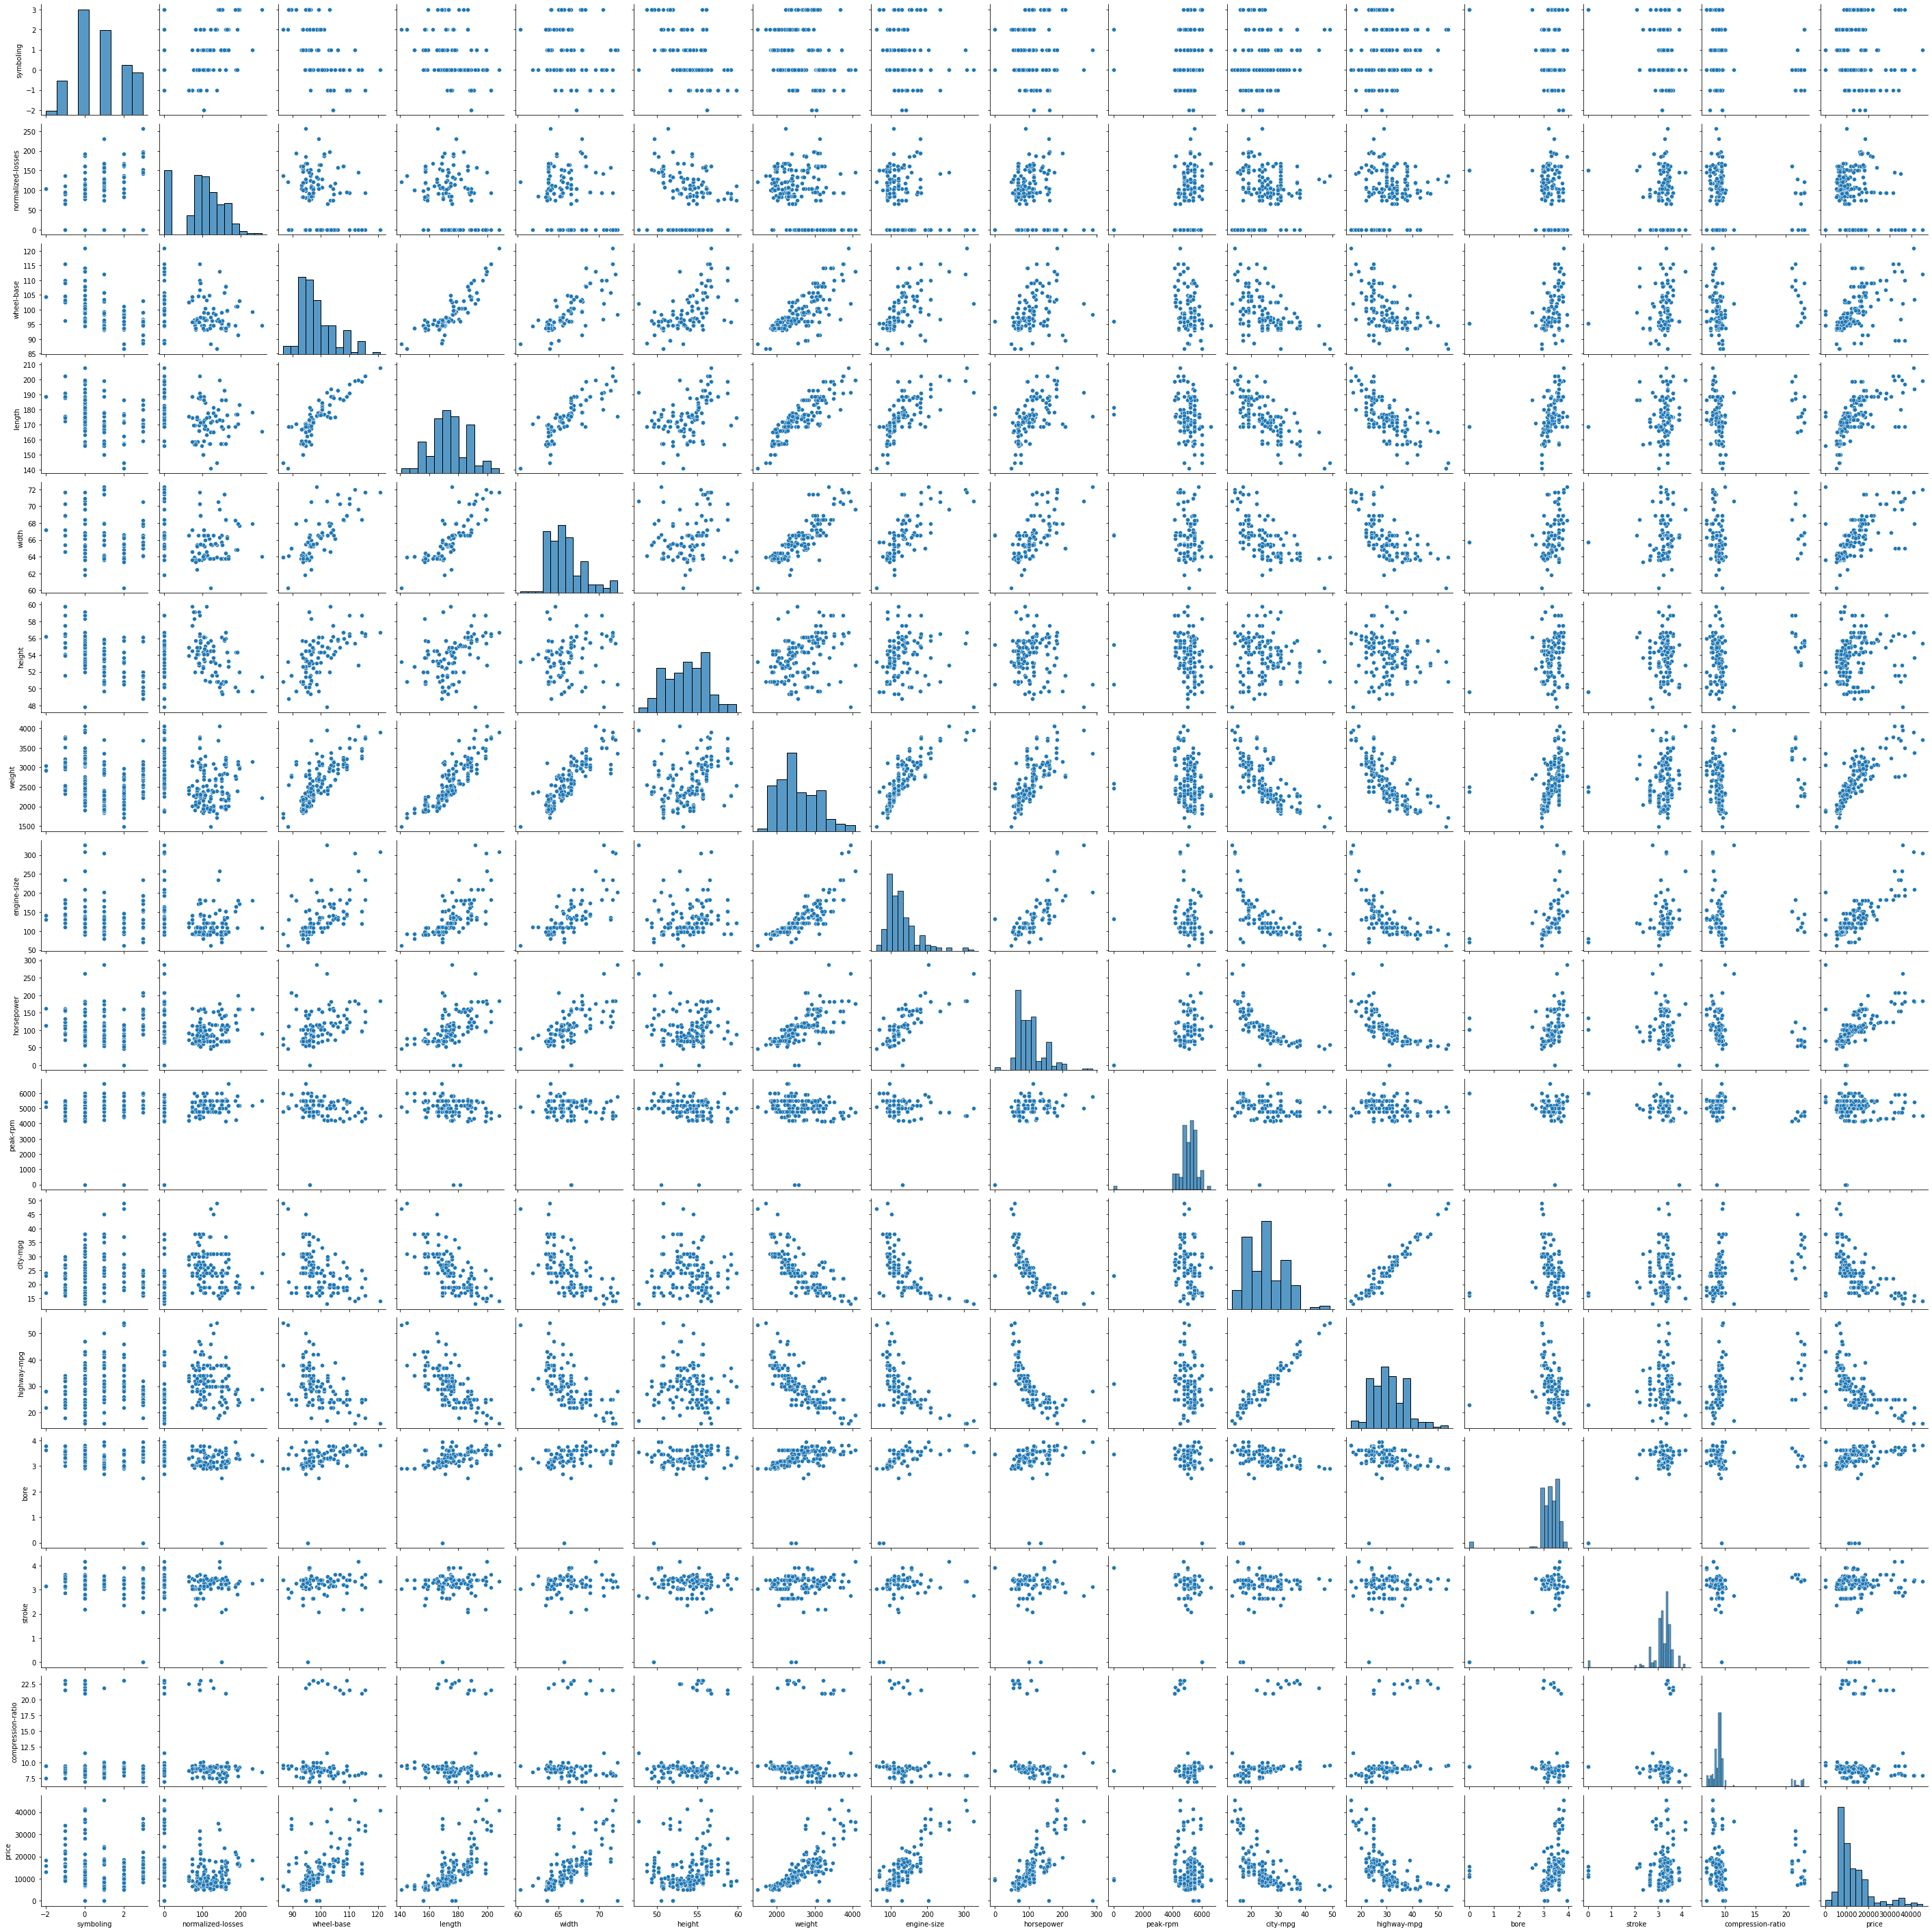

In [23]:
feature_list = ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'bore', 'stroke', 'compression-ratio', 'price']
sns.pairplot(car_data[feature_list], markers=["o", "s", "D"])

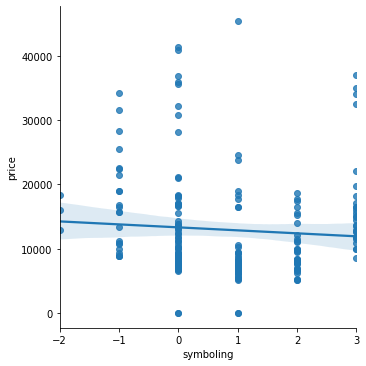

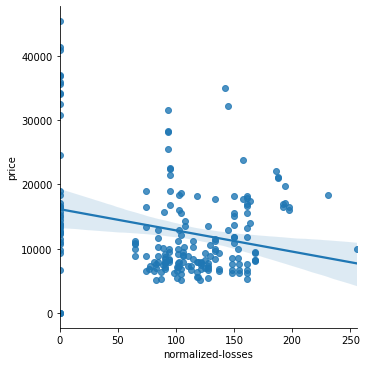

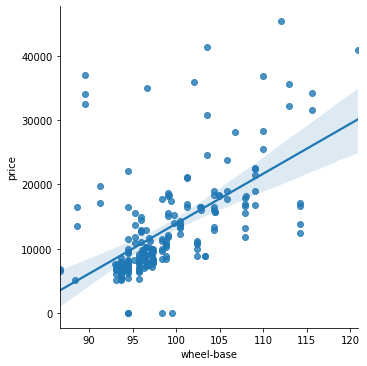

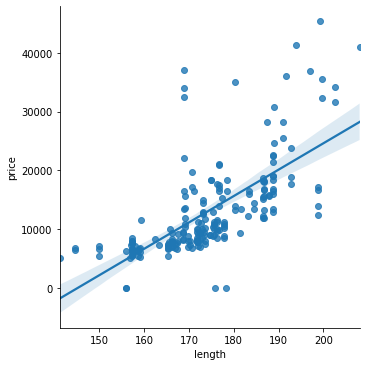

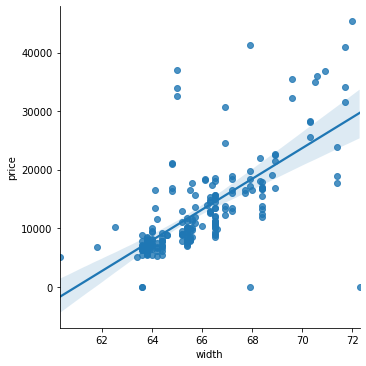

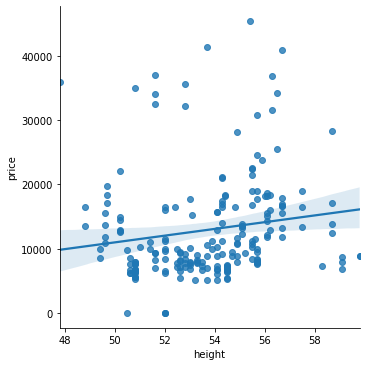

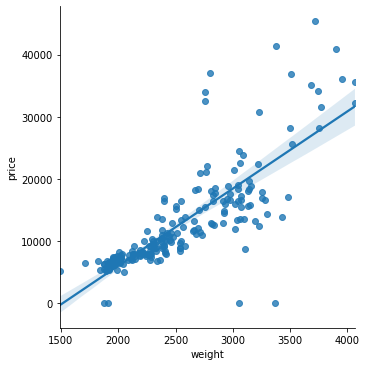

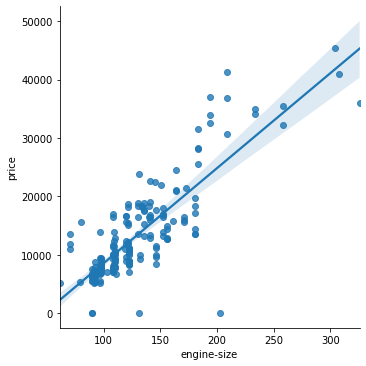

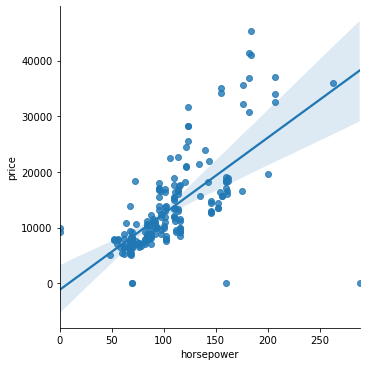

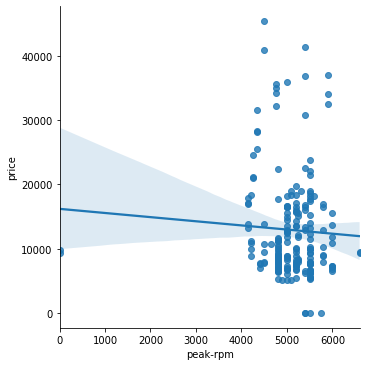

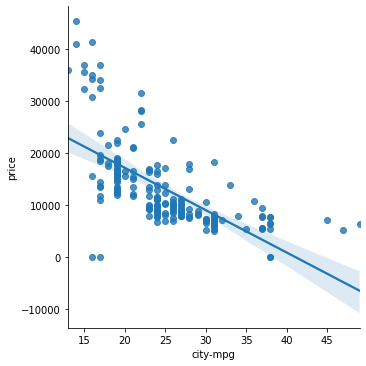

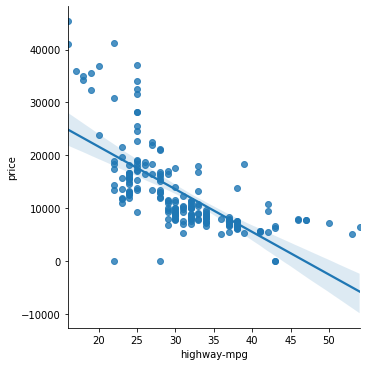

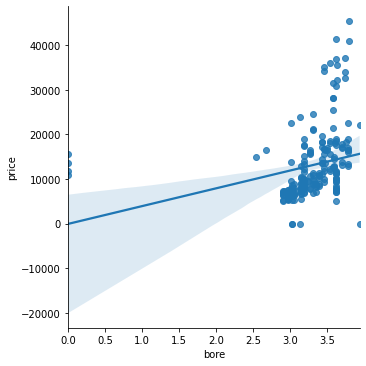

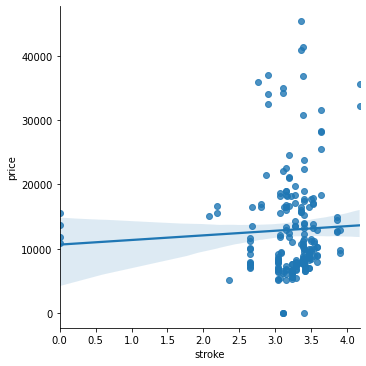

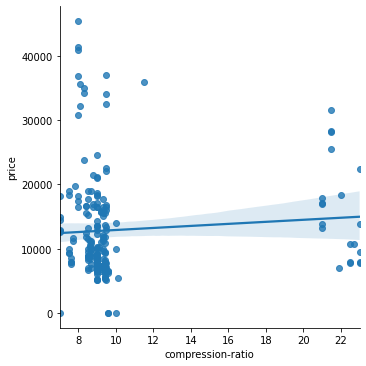

In [24]:
for n in feature_list[:-1]:
    sns.lmplot(x = n, y = 'price', data = car_data[feature_list])
    plt.show()

In [83]:
X1 = car_data[numeric_feature_names].iloc[0:1]
X1

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
85,1,125.00,96.30,172.40,65.40,51.60,2365,122,88.00,5000.00,25,32,3.35,3.46,8.50


In [80]:
y.iloc[0]

6989.0

In [63]:
X.head(2)

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
85,1,125.00,96.30,172.40,65.40,51.60,2365,122,88.00,5000.00,25,32,3.35,3.46,8.50
132,3,150.00,99.10,186.60,66.50,56.10,2658,121,110.00,5250.00,21,28,3.54,3.07,9.31


In [81]:
model.predict(X1)

array([[108.31718]], dtype=float32)

In [ ]:
model.predict(X1).item()

In [78]:
car_data['price']

85     6989.00
132   11850.00
140    7603.00
197   16515.00
107   11900.00
        ...   
29    12964.00
3     13950.00
176   10898.00
202   21485.00
28     8921.00
Name: price, Length: 205, dtype: float64

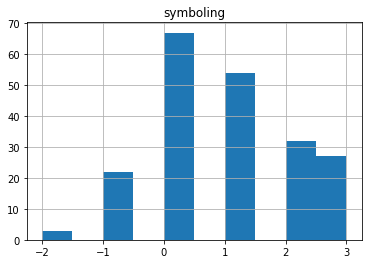

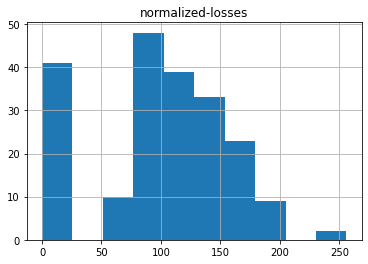

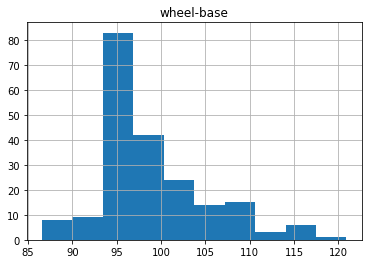

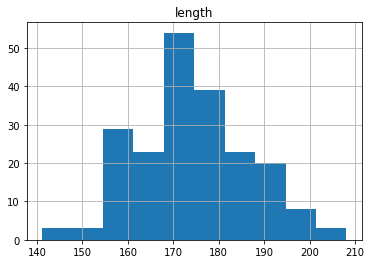

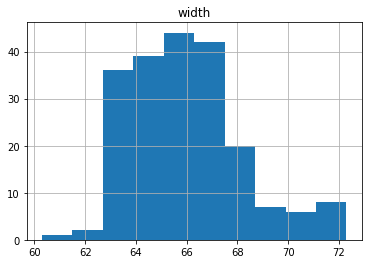

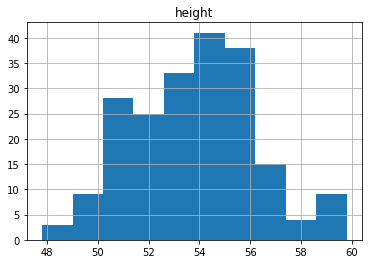

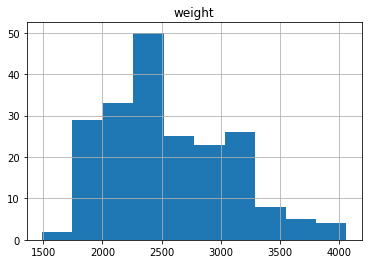

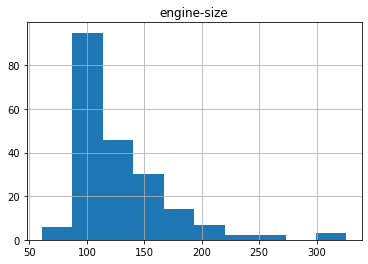

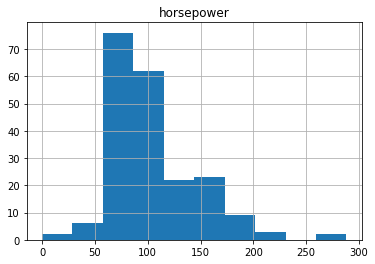

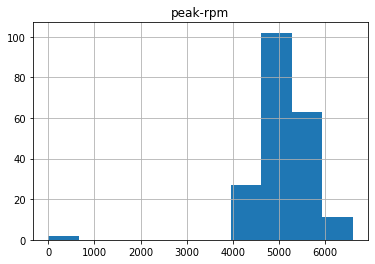

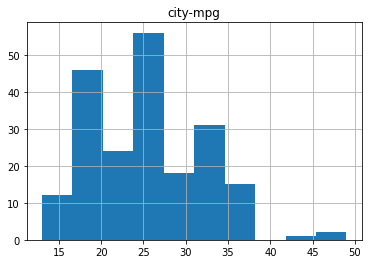

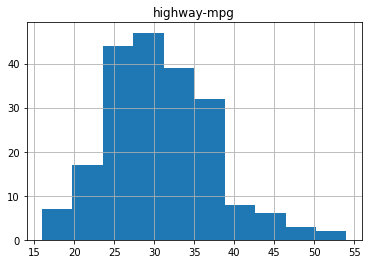

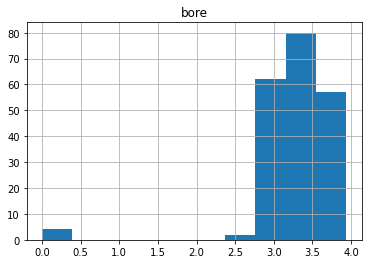

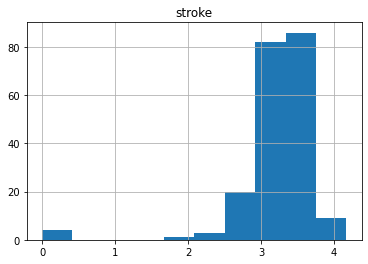

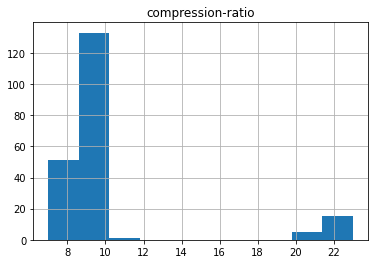

In [84]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)